# FYP - ReConYou

>> The Beginning

In [1]:
from pydub import AudioSegment #install pydub first from conda prompt..
from pydub.playback import play
import matplotlib.pyplot as plt
from IPython.display import Audio #for playing audio
import numpy as np 
import IPython.display as ipd
import sklearn 
import csv
import os
import pathlib
import pandas as pd
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split

In [ ]:
import keras
from keras import layers
from keras import layers
import keras
from keras.models import Sequential

> Loading Voice

In [2]:
song = AudioSegment.from_file("./Data/Saif/Saif1.wav")  #usually we observe that pydub doesn't support .m4a format but there might be a way..
song2 = AudioSegment.from_file("./Sample2.m4a")

In [3]:
if(song==song2):
    print("They are  equal !")
else:
    print("They are not equal !")

They are  equal !


> Basic Info

In [4]:
seg = AudioSegment.from_file("./Data/Saif/Saif1.wav")
print("Information:")
print("Channels:", seg.channels)
print("Bits per sample:", seg.sample_width * 8)
print("Sampling frequency:", seg.frame_rate)
print("Length:", seg.duration_seconds, "seconds")
print("Length of a song is ", len(seg),' seconds')

Information:
Channels: 1
Bits per sample: 16
Sampling frequency: 44100
Length: 2.1130158730158732 seconds
Length of a song is  2113  seconds


> Playing Audio

In [9]:
Audio("./Data/Anoshy/Anoshy1.wav")

> Function for Increasing speed of audio

In [6]:
def speed_change(sound, speed=1.0):
    # Manually override the frame_rate. This tells the computer how many
    # samples to play per second
    sound_with_altered_frame_rate = sound._spawn(sound.raw_data, overrides={
         "frame_rate": int(sound.frame_rate * speed)
      })
     # convert the sound with altered frame rate to a standard frame rate
     # so that regular playback programs will work right. They often only
     # know how to play audio at standard frame rate (like 44.1k)
    return sound_with_altered_frame_rate.set_frame_rate(sound.frame_rate)

In [7]:
fast_sound = speed_change(song, 2.0)

In [8]:
print("Length of a song:  ", len(song),' seconds')
print("Length of a song after 2X:  ", len(fast_sound),' seconds')

#tried different things to play .m4a in 2X but they didn't work.
#diverse options available for .wav should we go for that instead of .wav ????

Length of a song:   15859  seconds
Length of a song after 2X:   7930  seconds


# librosa 

> Turning audio into images..
>> images into numbers..
>>> :)) 

In [6]:
import librosa

# Load the audio file
AUDIO_FILE = "./Data/Saif/Saif5.wav"
samples, sample_rate = librosa.load(AUDIO_FILE, duration=1.9)

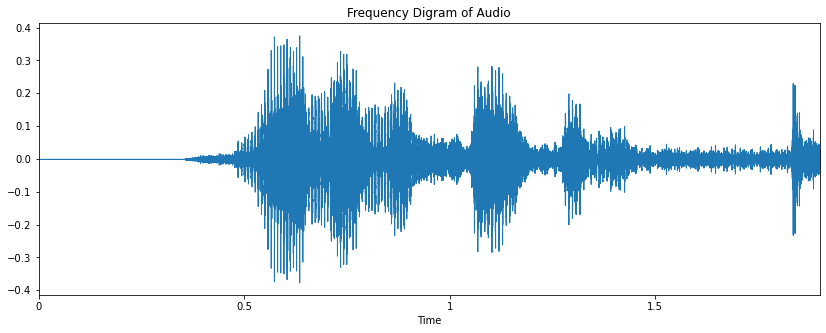

In [7]:
import librosa.display
import matplotlib.pyplot as plt

# x-axis has been converted to time using our sample rate. 
# matplotlib plt.plot(y), would output the same figure, but with sample 
# number on the x-axis instead of seconds
plt.figure(figsize=(14, 5))
plt.title("Frequency Digram of Audio")
librosa.display.waveplot(samples, sr=sample_rate)

> Spectograms

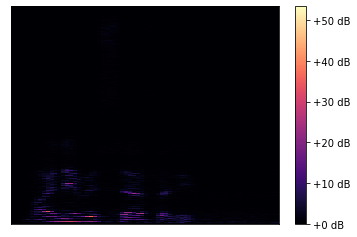

In [26]:
sgram = librosa.stft(samples)
librosa.display.specshow(sgram)
plt.colorbar(format='%+2.0f dB')

> Improving Spectogram

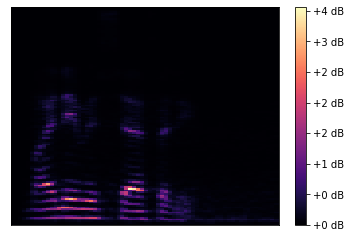

In [27]:
sgram_mag, _ = librosa.magphase(sgram)
mel_scale_sgram = librosa.feature.melspectrogram(S=sgram_mag, sr=sample_rate)
librosa.display.specshow(mel_scale_sgram)
plt.colorbar(format='%+2.0f dB')

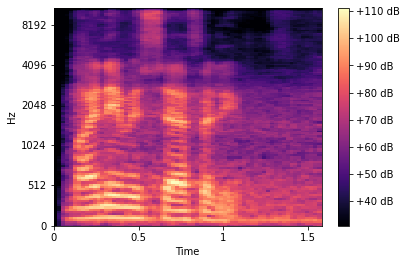

In [28]:
mel_sgram = librosa.amplitude_to_db(mel_scale_sgram, ref=np.min)
librosa.display.specshow(mel_sgram, sr=sample_rate, x_axis='time', y_axis='mel')
plt.colorbar(format='%+2.0f dB')

>> tester

In [25]:
cmap = plt.get_cmap('inferno')
plt.figure(figsize=(8,8))
speakers = 'saif ali ahmed umair'.split()
for g in speakers:
    pathlib.Path(f'img_data/{g}').mkdir(parents=True, exist_ok=True)
    for filename in os.listdir(f'./M4a_files/{g}'):
        songname = f'./M4a_files/{g}/{filename}'
        y, sr = librosa.load(songname, mono=True, duration=5)
        plt.specgram(y, NFFT=2048, Fs=2, Fc=0, noverlap=128, cmap=cmap, sides='default', mode='default', scale='dB');
        plt.axis('off');
        plt.savefig(f'img_data/{g}/{filename[:-3].replace(".", "")}.png')
        plt.clf()

<Figure size 576x576 with 0 Axes>

In [26]:
header = 'Speaker spectral_centroid spectral_bandwidth rolloff zero_crossing_rate'
for i in range(1, 21):
    header += f' mfcc{i}'
header += ' label'
header = header.split()

In [27]:
file = open('dataset.csv', 'w', newline='')
with file:
    writer = csv.writer(file)
    writer.writerow(header)
speakers = 'saif ali ahmed umair'.split()
for g in speakers:
    for filename in os.listdir(f'./M4a_files/{g}'):
        songname = f'./M4a_files/{g}/{filename}'   #filename is referred to .png
        y, sr = librosa.load(songname, mono=True, duration=30)
        chroma_stft = librosa.feature.chroma_stft(y=y, sr=sr)
        spec_cent = librosa.feature.spectral_centroid(y=y, sr=sr)
        spec_bw = librosa.feature.spectral_bandwidth(y=y, sr=sr)
        rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr)
        zcr = librosa.feature.zero_crossing_rate(y)
        mfcc = librosa.feature.mfcc(y=y, sr=sr)
        to_append = f'{filename} {np.mean(chroma_stft)} {np.mean(spec_cent)} {np.mean(spec_bw)} {np.mean(rolloff)} {np.mean(zcr)}'
        for e in mfcc:
            to_append += f' {np.mean(e)}'
        to_append += f'{g}'
        file = open('dataset.csv', 'a', newline='')
        with file:
            writer = csv.writer(file)
            writer.writerow(to_append.split())

In [14]:
data = pd.read_csv('dataset.csv')
data.head()# Dropping unneccesary columns
data = data.drop(['Speaker'],axis=1)#Encoding the Labels
genre_list = data.iloc[:, -1]
encoder = LabelEncoder()
y = encoder.fit_transform(genre_list)#Scaling the Feature columns
scaler = StandardScaler()
X = scaler.fit_transform(np.array(data.iloc[:, :-1], dtype = float))#Dividing data into training and Testing set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [ ]:
model = Sequential()
model.add(layers.Dense(256, activation='relu', input_shape=(X_train.shape[1],)))
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(10, activation='softmax'))
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

>>> Until Now

> Code For Converting .m4a files into .wav files

In [1]:
import os
import argparse

from pydub import AudioSegment

formats_to_convert = ['.m4a']

for (dirpath, dirnames, filenames) in os.walk("Datas/"):
    for filename in filenames:
        if filename.endswith(tuple(formats_to_convert)):

            filepath = dirpath + '/' + filename
            (path, file_extension) = os.path.splitext(filepath)
            file_extension_final = file_extension.replace('.', '')
            try:
                track = AudioSegment.from_file(filepath,
                        file_extension_final)
                wav_filename = filename.replace(file_extension_final, 'wav')
                wav_path = dirpath + '/' + wav_filename
                print('CONVERTING: ' + str(filepath))
                file_handle = track.export(wav_path, format='wav')
                os.remove(filepath)
            except:
                print("ERROR CONVERTING " + str(filepath))

CONVERTING: Datas/Saif/Saif.m4a
CONVERTING: Datas/Saif/Saif11.m4a
CONVERTING: Datas/Saif/Saifff.m4a


> Code for Recording and Saving file

In [16]:
import sounddevice as sd
from scipy.io.wavfile import write

fs = 44100  # Sample rate
seconds = 5  # Duration of recording

myrecording = sd.rec(int(seconds * fs), samplerate=fs, channels=2)
print('Recording Speak Now! ')
sd.wait()  # Wait until recording is finished
print('<Recorded>')
x = input("Write The Name Of User: ")
write(x+'/output2.wav', fs, myrecording)  # Save as WAV file 
print('Your Recording has been Saved Succesfully.')


Recording Speak Now! 
<Recorded>
Write The Name Of User: M4a_files
Your Recording has been Saved Succesfully.


> Trimming Audio

In [ ]:
from pydub import AudioSegment

files_path = ''
file_name = ''

startMin = 0
startSec = 2

endMin = 0
endSec = 10

# Time to miliseconds
startTime = startMin*60*1000+startSec*1000
endTime = endMin*60*1000+endSec*1000

# Opening file and extracting segment
song = AudioSegment.from_mp3( files_path+file_name+'.mp3' )
extract = song[startTime:endTime]

# Saving
extract.export( file_name+'-extract.mp3', format="mp3")

# Feature Extraction

> Zero Crossing Rate

In [26]:
x, sr = librosa.load('./sample2.m4a')
ipd.Audio(x, rate=sr)

D:\anaconda3\lib\site-packages\librosa\core\audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


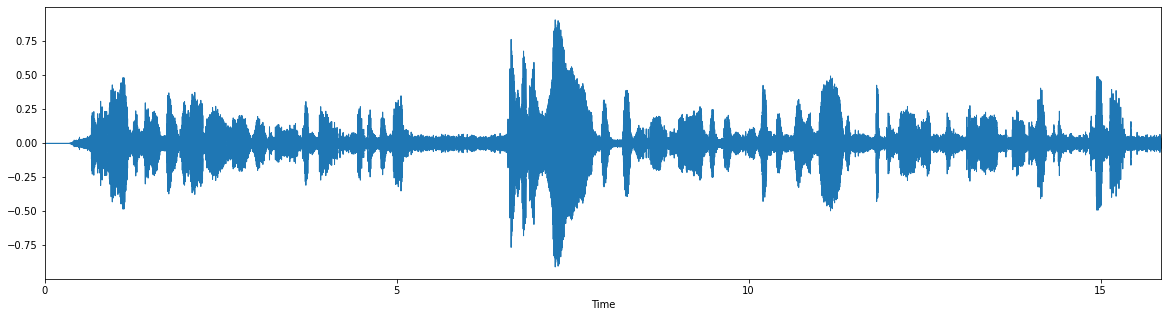

In [27]:
plt.figure(figsize=(20, 5))
librosa.display.waveplot(x, sr=sr)

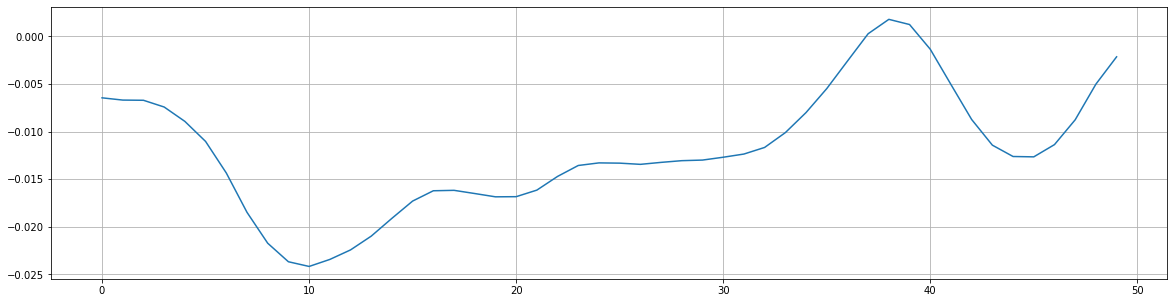

In [35]:
# Zooming in
n0 = 9000
n1 = 9050
plt.figure(figsize=(20, 5))
plt.plot(x[n0:n1])
plt.grid()

In [36]:
zero_crossings = librosa.zero_crossings(x[n0:n1], pad=False)
zero_crossings.shape

(50,)

In [37]:
print(sum(zero_crossings))

2


> Spectral Centroids

In [41]:
spectral_centroids = librosa.feature.spectral_centroid(x, sr=sr)[0]
spectral_centroids.shape

(684,)

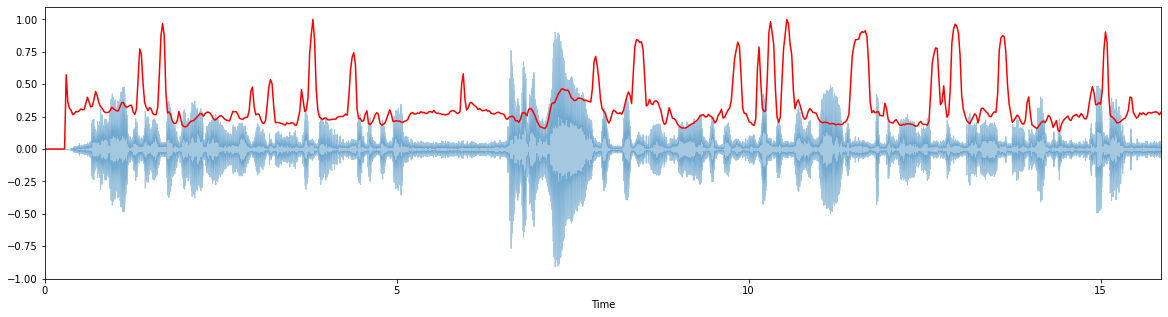

In [43]:
plt.figure(figsize=(20,5))
frames = range(len(spectral_centroids))
t = librosa.frames_to_time(frames)

# Normalising the spectral centroid for visualisation
def normalize(x, axis=0):
    return sklearn.preprocessing.minmax_scale(x, axis=axis)

#Plotting the Spectral Centroid along the waveform
librosa.display.waveplot(x, sr=sr, alpha=0.4)
plt.plot(t, normalize(spectral_centroids), color='r')

> Spectral RolloFF

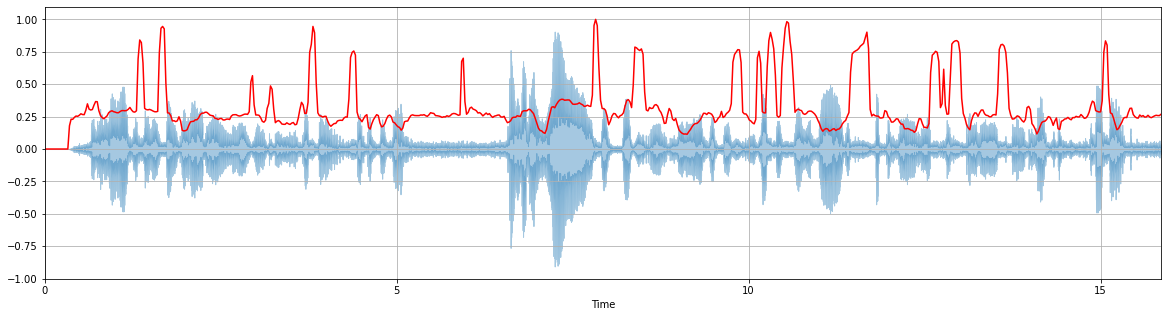

In [45]:
plt.figure(figsize=(20,5))
spectral_rolloff = librosa.feature.spectral_rolloff(x+0.01, sr=sr)[0]
librosa.display.waveplot(x, sr=sr, alpha=0.4)
plt.plot(t, normalize(spectral_rolloff), color='r')
plt.grid()

(20, 684)


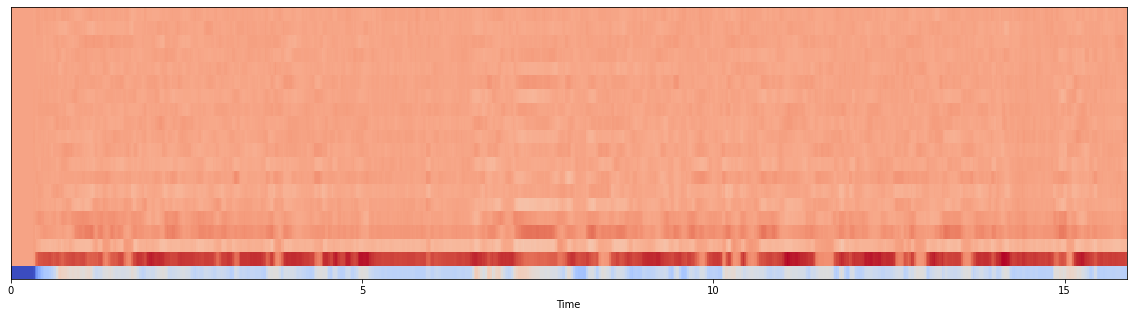

In [50]:
plt.figure(figsize=(20,5))
mfccs = librosa.feature.mfcc(x, sr=sr)
print(mfccs.shape)

librosa.display.specshow(mfccs, sr=sr, x_axis='time')

# Extracting Feautures From Audio

In [ ]:
cmap = plt.get_cmap('inferno')
plt.figure(figsize=(8,8))
speakers = 'saif mahnoor saud tariq qasim'.split()
for g in speakers:
    pathlib.Path(f'img_data/{g}').mkdir(parents=True, exist_ok=True)
    for filename in os.listdir(f'./drive/My Drive/genres/{g}'):
        songname = f'./drive/My Drive/genres/{g}/{filename}'
        y, sr = librosa.load(songname, mono=True, duration=5)
        plt.specgram(y, NFFT=2048, Fs=2, Fc=0, noverlap=128, cmap=cmap, sides='default', mode='default', scale='dB');
        plt.axis('off');
        plt.savefig(f'img_data/{g}/{filename[:-3].replace(".", "")}.png')
        plt.clf()
